
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")

# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing expert tasked with creating well-crafted, coherent, and engaging articles based on the user's request, writing good quality code, well structured reports"
            " Focus on quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
# writer = writer_prompt | ChatOllama(
#     model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=1.2,
# )

writer = writer_prompt | llm

In [6]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

为了更好地展示《水浒传》的风格，我将改写吴承恩的《西游记》第一天章，八十一难之一，让我们将孙悟空、唐僧、猪八戒和沙僧的历险过程转化为《水浒传》中热血沸腾、英雄豪情的叙述方式。

---

天宫，破敌显威**

水，终于抵达那处名为“狮子山”的险地。此山高耸入云，苍松巨石，宛如猛狮卧伏，令人心生畏惧。四人中，悟空更是不惧，只因那铁棒举世无敌，若有妖孽在此，定让其无所遁形。

正当师徒四人欲稍作休息，忽见一妖风阵阵，伴着呼号之声，山中竟然隐现众妖，个个头戴獠牙，咧嘴而笑，满脸凶狠。看这阵势，分明是来自魔界的恶徒，意图攫取唐僧之肉，得道升天。

悟空早已看出这妖邪不善，面目一冷，怒声道：“后方妖贼，胆敢妨碍我取经，我自会与你们一战！”言罢，手中金箍棒已然舞动，如同闪电般击向那妖群。那妖们虽拥众多，却见悟空神勇无比，剑拔弩张，个个心中惧怕，纷纷后退，生怕被这蓦然现身的妖猴所伤。

时，猪八戒见势不妙，贪心之念又起，催促道：“师兄，莫再留手，这些妖邪根本不是我等之敌，让我来搭救师傅！”虽说八戒本无异心，然却因其贪恋美食，忠诚之心有时不免被欲念迷惑。沙僧却是沉稳，言至：“若是敌强我弱，别无他法，还是小心应对为上。”

拿出如意金箍棒，飞身前进，只见他一棒劈去，风中瞬间产生雷鸣之声，妖群纷纷东倒西歪，个个无能为力。片刻之间，众妖皆被打散，徒留一头目鬼吓得瑟瑟发抖，惶恐道：“高明的齐天大圣，饶命啊！我等不敢再犯！”

乖乖退去，方可保全性命，若乃执迷不悟，定叫你们后悔无及！”目鬼复恐惧，连忙点头称是，立刻逃之夭夭，恨不得三头六臂也不敢回首。

我这一路虽险，但幸有二位斩妖除魔，保我周全，才让我等能继续西行，问取真经。”众人皆颔首，决定继续向前，志在取得真经，全都心中充满豪情，乘风破浪，再登高峰。

---

浒传》风格的改写，望能传达两部作品的精神与气概。如果您有更具体的需求或改动意见，请随时告知！

In [7]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

为了更好地展示《水浒传》的风格，我将改写吴承恩的《西游记》第一天章，八十一难之一，让我们将孙悟空、唐僧、猪八戒和沙僧的历险过程转化为《水浒传》中热血沸腾、英雄豪情的叙述方式。

---

**大闹天宫，破敌显威**

话说那唐僧师徒四人，携卷而行，途经千山万水，终于抵达那处名为“狮子山”的险地。此山高耸入云，苍松巨石，宛如猛狮卧伏，令人心生畏惧。四人中，悟空更是不惧，只因那铁棒举世无敌，若有妖孽在此，定让其无所遁形。

正当师徒四人欲稍作休息，忽见一妖风阵阵，伴着呼号之声，山中竟然隐现众妖，个个头戴獠牙，咧嘴而笑，满脸凶狠。看这阵势，分明是来自魔界的恶徒，意图攫取唐僧之肉，得道升天。

悟空早已看出这妖邪不善，面目一冷，怒声道：“后方妖贼，胆敢妨碍我取经，我自会与你们一战！”言罢，手中金箍棒已然舞动，如同闪电般击向那妖群。那妖们虽拥众多，却见悟空神勇无比，剑拔弩张，个个心中惧怕，纷纷后退，生怕被这蓦然现身的妖猴所伤。

这时，猪八戒见势不妙，贪心之念又起，催促道：“师兄，莫再留手，这些妖邪根本不是我等之敌，让我来搭救师傅！”虽说八戒本无异心，然却因其贪恋美食，忠诚之心有时不免被欲念迷惑。沙僧却是沉稳，言至：“若是敌强我弱，别无他法，还是小心应对为上。”

四人众志成城，悟空拿出如意金箍棒，飞身前进，只见他一棒劈去，风中瞬间产生雷鸣之声，妖群纷纷东倒西歪，个个无能为力。片刻之间，众妖皆被打散，徒留一头目鬼吓得瑟瑟发抖，惶恐道：“高明的齐天大圣，饶命啊！我等不敢再犯！”

悟空冷酷一笑：“尔等这般贪婪，为何不再自省？如今乖乖退去，方可保全性命，若乃执迷不悟，定叫你们后悔无及！”目鬼复恐惧，连忙点头称是，立刻逃之夭夭，恨不得三头六臂也不敢回首。

这番战斗过后，四人方得安稳，唐僧感慨道：“我这一路虽险，但幸有二位斩妖除魔，保我周全，才让我等能继续西行，问取真经。”众人皆颔首，决定继续向前，志在取得真经，全都心中充满豪情，乘风破浪，再登高峰。

---

以上是将《西游记》第一天章以《水浒传》风格的改写，望能传达两部作品的精神与气概。如果您有更具体的需求或改动意见，请随时告知！

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [9]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a good teacher have multiple skills: 1. grading an article submission. writer critique and recommendations for the user's submission.2.write good quality code. 3.write good quality of report"
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# reflect = reflection_prompt | ChatOllama(
#     model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=0.2,
# )
reflect = reflection_prompt | llm

In [10]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

你的改写作品展现了《水浒传》的豪情与气概，同时将《西游记》的经典情节进行了生动的重构。以下是一些具体的评价和建议，希望能帮助你进一步完善这部作品：

### 优点：
你成功地捕捉了《水浒传》中特有的叙述风格，通过激昂的语言和鲜明的描绘，让人物个性和事件冲突更为突出。
情节，保持了故事的连贯性和逻辑性。保留了《西游记》的核心
：对孙悟空的正义感、猪八戒的贪恋和沙僧的冷静均有恰当渲染，增强了角色的立体感。

### 改进建议：
深度**：可以进一步丰富语言的多样性，例如使用更多的修辞手法和古风词汇，增加文本的韵律感和历史感，使其更贴合《水浒传》的语言风格。
加入更多生动的比喻和形容词，增强视觉冲击和情感共鸣。

 **段落安排**：考虑对部分段落进行拆分，增加小节，以使难度分明、条理更清晰。例如，妖怪的出现、战斗开始和胜利后的反思可以分为独立的小段，强调每一个环节的重点。

染**：在描写唐僧感慨的部分，能够更加深入地表达他内心的复杂情感，比如对于取经路途艰险的担忧，以及对师徒之间情谊的珍视，增加人物的情感层次。

的描写，比如悟空施展法术的细节、妖怪们的反应等，进一步增强故事的游戏性与现场感，增加读者的沉浸体验。

5. **文化背景**：加入一些对妖怪来源和背景的简单描述，可以为读者补充更丰富的文化信息，同时也为角色目标的实现提供更好的动机。

### 结论：
了很好的效果，成功还原了两部作品的精髓。特别是在角色的个性描绘和情节进展上表现突出。希望我的建议能够帮助你进一步增强作品的吸引力，使其更加完美。如有其他方面的需求，欢迎随时交流！

In [11]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

你的改写作品展现了《水浒传》的豪情与气概，同时将《西游记》的经典情节进行了生动的重构。以下是一些具体的评价和建议，希望能帮助你进一步完善这部作品：

### 优点：
1. **风格把握**：你成功地捕捉了《水浒传》中特有的叙述风格，通过激昂的语言和鲜明的描绘，让人物个性和事件冲突更为突出。
2. **情节发展**：改写过程中保留了《西游记》的核心情节，保持了故事的连贯性和逻辑性。
3. **人物塑造**：对孙悟空的正义感、猪八戒的贪恋和沙僧的冷静均有恰当渲染，增强了角色的立体感。

### 改进建议：
1. **语言深度**：可以进一步丰富语言的多样性，例如使用更多的修辞手法和古风词汇，增加文本的韵律感和历史感，使其更贴合《水浒传》的语言风格。
   - 例如，可以在描写妖怪时加入更多生动的比喻和形容词，增强视觉冲击和情感共鸣。

2. **段落安排**：考虑对部分段落进行拆分，增加小节，以使难度分明、条理更清晰。例如，妖怪的出现、战斗开始和胜利后的反思可以分为独立的小段，强调每一个环节的重点。

3. **情感渲染**：在描写唐僧感慨的部分，能够更加深入地表达他内心的复杂情感，比如对于取经路途艰险的担忧，以及对师徒之间情谊的珍视，增加人物的情感层次。

4. **长度与深度**：如果需要扩展，可以增加对战斗过程的描写，比如悟空施展法术的细节、妖怪们的反应等，进一步增强故事的游戏性与现场感，增加读者的沉浸体验。

5. **文化背景**：加入一些对妖怪来源和背景的简单描述，可以为读者补充更丰富的文化信息，同时也为角色目标的实现提供更好的动机。

### 结论：
总体而言，你的改写取得了很好的效果，成功还原了两部作品的精髓。特别是在角色的个性描绘和情节进展上表现突出。希望我的建议能够帮助你进一步增强作品的吸引力，使其更加完美。如有其他方面的需求，欢迎随时交流！

In [12]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [13]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [14]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

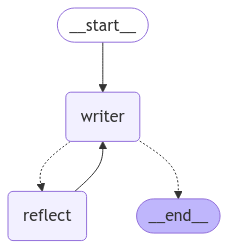

In [15]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [16]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [ ]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，根据写一篇唐僧的现代述职报告")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- **唐僧现代述职报告**

尊敬的领导、亲爱的同仁们：

在这阳光普照的日子里，我怀着一颗虔诚而感激的心，向大家汇报我过去一段时间的工作情况。如同历经九九八十一难，我在这段时间中也经历了许多挑战与成长。

**一、工作目标的落实**

在过去的时间里，我全面深入贯彻了“取经”的重大使命，目标明确，任务清晰。在帮助弟子们成长的同时，我秉持着为民众传播佛法的宗旨，力求使各项工作的开展更为顺利。我经常在团队内分享经文与智慧，以期共同成长，也期望弟子们在攀登知识的高峰时，能有所领悟，抚慰众生的心灵。

**二、团队建设与管理**

在团队方面，我与孙悟空、猪八戒、沙僧三位弟子，充分发挥各自的特长，形成了合力。在取经的路途中，遇险时我始终鼓励弟子们勇往直前，面对困难不退缩。通过定期的团建活动，我们增进了情感，增强了团队的凝聚力与战斗力。

**三、问题与挑战的应对**

在工作中难免遇到阻碍。如牛魔王的纠缠与白骨精的诱惑，皆为考验，亦是成长的机会。我认真总结每一次的经验教训，带领弟子们不断调整前进的策略。每当面临困难时，我总是铭记“忍辱负重”的道理，以平和的心态分析问题，找到解决方案。

**四、未来工作的展望**

展望未来，我将继续弘扬真理，传播正信。我期望能带领团队走出更广阔的天地，让我们的取经之路更加顺利。在此过程中，我会始终保持虚心向前的态度，努力学习更多的知识，为我们的使命投入更多的热情与智慧。

在此，我衷心感谢每一位同仁的支持与辛勤付出，愿我们在接下来的日子里，携手共进，齐心协力，让我们的事业如同取经的路途一般，充满胜利的光辉！

谢谢大家！

                                                  — 唐长老驻笔于此


## Round 2

#### 评论反思:
- ### 唐僧现代述职报告

尊敬的领导、亲爱的同仁们：

在这阳光明媚、万物复苏的时节，我怀着一颗感恩而虔诚的心，向大家致以诚挚的问候，并汇报我过去一段时间的工作情况。正如我在取经路上所经历的九九八十一难，我在工作中也面临了诸多挑战与洗礼，造就了我的成长与蜕变。

#### 一、认真贯彻工作的使命

在过去的时间里，我始终不忘初心，明确自己的“取经”使命。我的目标是将博大精深的佛法传递给更多的人，助力于心灵的启迪与升华。我积极参与各项活动，并在团队内分享经典的智慧，期望通过共同的学习与实践，让每位成员在思想上获得升华、在行动上有所发挥。

#### 二、团队建设与协作

我深知，团队的力量乃是成功之本。与孙悟空、猪八戒、沙僧三位弟子密切协作，各自发挥特长，形成强大的团队合力。在面对艰难险阻时，我时常鼓励弟子们勇往直前，积极面对，决不退缩。通过组织定期的团建活动，我们不仅增强了团队的凝聚力，还加深了彼此之间的理解和信任，为共同的目标奋斗。

#### 三、妥善应对挑战与问题

工作中总会遭遇困难与挑战，正如牛魔王的纠缠和白骨精的考验，都让我深刻意识到成长的真谛。我细心总结每一次的经验教训，以此指导团队的未来方向。在面对艰难时，我始终铭记“忍辱负重”的经典教诲，以理智和冷静分析问题，从而寻找合适的解决方案，带领弟子们不断前行。

#### 四、未来的展望与计划

展望未来，我将继续坚守信念，弘扬真理，传播正信。我期望引领团队走向更为广阔的天地，提升我们的执行力与影响力。为此，我将继续保持学习的热情，汲取更多的知识与经验，努力为我们的共同事业贡献更多价值。

在此，我衷心感谢各位同仁的支持与奉献，正是你们的辛勤付出与团结协作，才让我们的事业不断向前推进。愿我们携手并肩，共同努力，让我们的工作之路如同西天取经般，满载荣耀与丰收！

谢谢大家！

— 唐长老谨呈


## Round 3

#### 写作生成:
- ### 唐僧现代述职报告

尊敬的领导、亲爱的同仁们：

在这阳光明媚、万物复苏的时节，我怀着一颗感恩而虔诚的心，向大家致以诚挚的问候，并汇报我过去一段时间的工作情况。正如我在取经路上所经历的九九八十一难，我在工作中也面临了诸多挑战与洗礼，造就了我的成长与蜕变。

#### 一、认真贯彻工作的使命

在过去的时间里，我始终不忘初心，明确自己的“取经”使命。我的目标是将博大精深的佛法传递给更多的人，助力于心灵的启迪与升华。我积极参与各项活动，并在团队内分享经典的智慧，以期通过共同的学习与实践，让每位成员在思想上获得升华、在行动上有所发挥。

#### 二、团队建设与协作

我深知，团队的力量乃是成功之本。与孙悟空、猪八戒、沙僧三位弟子密切协作，各自发挥特长，形成强大的团队合力。在面对艰难险阻时，我时常鼓励弟子们勇往直前，积极面对，决不退缩。通过组织定期的团建活动，我们不仅增强了团队的凝聚力，还加深了彼此之间的理解和信任，为共同的目标奋斗。

#### 三、妥善应对挑战与问题

工作中总会遭遇困难与挑战，正如牛魔王的纠缠和白骨精的考验，都让我深刻意识到成长的真谛。我细心总结每一次的经验教训，以此指导团队的未来方向。在面对艰难时，我始终铭记“忍辱负重”的经典教诲，以理智和冷静分析问题，从而寻找合适的解决方案，带领弟子们不断前行。

#### 四、未来的展望与计划

展望未来，我将继续坚守信念，弘扬真理，传播正信。我期望引领团队走向更为广阔的天地，提升我们的执行力与影响力。为此，我将继续保持学习的热情，汲取更多的知识与经验，努力为我们的共同事业贡献更多价值。

在此，我衷心感谢各位同仁的支持与奉献，正是你们的辛勤付出与团结协作，才让我们的事业不断向前推进。愿我们携手并肩，共同努力，让我们的工作之路如同西天取经般，满载荣耀与丰收！

谢谢大家！

— 唐长老谨呈


## Round 4

#### 评论反思:
- ### 唐僧现代述职报告

尊敬的领导、亲爱的同仁们：

在这普照阳光、万物复苏的时节，我怀着一颗满怀感恩与虔诚的心，向大家致以诚挚的问候，并汇报我过去一段时间的工作情况。正如我在西天取经途中所经历的九九八十一难，我在这条职场道路上同样面临了种种挑战与洗礼，收获了成长与启迪。

#### 一、克服困难，努力落实工作使命

在此期间，我始终坚定不移地坚持“取经”的使命。我的目标是将博大精深的佛法传播给更多的人，帮助他们心灵的启迪与升华。我通过多样化的活动与会议积极参与，分享经典智慧，激励团队共同学习、不断进步。希望通过这样的方法，使每位同仁都能在思想和行动上有所提升。

#### 二、强化团队建设，增强合作意识

深知团队的力量乃是成功的关键，我与孙悟空、猪八戒、沙僧三位弟子紧密合作，充分发挥各自特长，形成强大的合作效应。在面对艰难险阻时，我始终鼓励弟子勇于面对、不怕挑战。在定期的团队活动中，我们不仅增强了沟通，还加深了彼此间的信任与理解，使得团队的凝聚力愈加增强，积极为共同目标奋斗。

#### 三、应对挑战，注重经验积累

在工作中遭遇的困扰与障碍，如牛魔王的纠缠与白骨精的诱惑，都是我成长的重要契机。我认真总结每次经历，反思其中的经验教训，从中提炼出指导团队前行的策略。面对挑战，我铭记“忍辱负重”的道理，以冷静和理性的态度分析问题，寻找合适的解决方案，带领弟子不断向前迈进。

#### 四、未来工作展望及期待

展望未来，我将继续坚持自己的信念，弘扬真理，传播正信。我期待引领团队走向更为广阔的天地，提升我们的执行力与影响力。在这一过程中，我会保持积极学习的态度，汲取更多的知识与经验，为我们的事业奉献更多的热情与智慧。

在此，我衷心感谢在座的每一位同仁，是你们的协作与奉献，让我们的事业不断向前推进。愿我们携手并肩，奋发向上，让我们的工作之路如同取经的旅途，满载辉煌与收获！

谢谢大家！

— 唐长老谨呈


In [ ]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。